# TP $k$ Nearest Neighbors

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success">
    <b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [ ]:
# !unzip TP_knn.zip


In [5]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
import matplotlib.pyplot as plt

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits, but in this notebook, we will use the first split and do our own cross-validation routines.

0


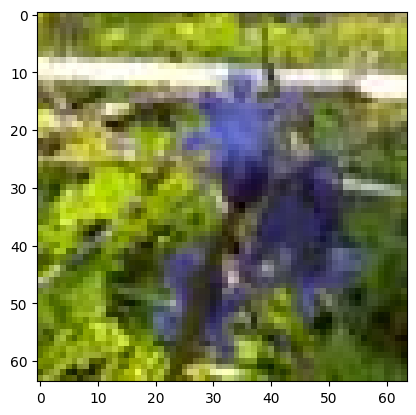

In [6]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds]) # put images between -1 and 1
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds]) # put images between -1 and 1
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])

Next, we define the 0-1 loss that measures the error rate of a classifier.

In [7]:
def error_rate(y_hat, y):
    return (1.-(y_hat==y)).mean()

## Implementing a simple $k$-NN


<div class="alert alert-success"> <b> Q1.</b>
Implement the code of the $k$-NN classifier in the following class. It has to work for any value of $k$ and any number of classes in $\mathcal{Y}$. Make sure it does not have any explicit loop and that it runs instantaneously. We first try a simple 1-NN on the full training set to check that our code works. I found around 14% error (compared to 90% for random guesses). <i>(Indicative time: maximum 45 minutes, should run in less than 2 seconds)</i>
</div>


In [8]:
class KNearestNeighbor():
    def __init__(self, X, y, k=1):
        self.X = X
        self.y = jnn.one_hot(y, 12)
        self.k = k

    '''
    x is a matrix nxd of n samples of dimension d
    returns a vector of size n containing the prediction of the class
    '''
    def __call__(self, x):
        ## TODO
        norms1 = jnp.sum(jnp.square(self.X), axis=1)
        norms2 = jnp.sum(jnp.square(x), axis=1)
        D =  np.dot(x, self.X.T)
        dist = (norms1[None,:] + norms2[:,None] - 2*D)
        indices = jnp.argsort(dist, axis=1)
        most_frequent_value = jnp.argmax((self.y[indices[:,0:self.k]]).sum(axis=1), axis=-1)

        return most_frequent_value

In [9]:
nn = KNearestNeighbor(X_train, y_train, k=1)
y_hat = nn(X_val)
err = error_rate(y_hat, y_val)
print(err)


0.4466667


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  Answer
</div>

## selecting $k$ using cross-validation

Next, we want to select the optimal value for $k$ using K-Fold cross-validation.

<div class="alert alert-success"> <b>Q2. </b>
Code a routine that performs 10-Fold cross-validation, use it to plot the average and stddev error rate  of the $k$-NN classifier for $k$ varying from 1 to 32 by power of 2. Make sure it runs quasi-instantaneously for each $k$ and that it only has one explicit loop in the routine (the one over the splits) and only one outside (the one over $k$). I found around 8 to perform best <i>(indicative time: maximum 45 minutes, should run in less than 1 minute)</i>
</div>

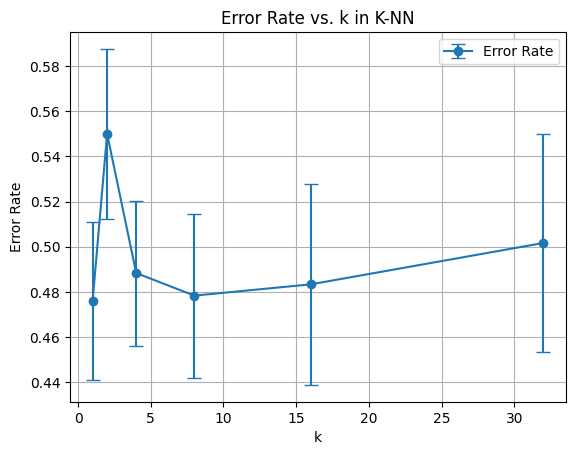

In [10]:
from jax import random

def tenfold(cls, X, y, k):
    ## TODO
    key = jax.random.PRNGKey(32)
    n = X.shape[0]
    key, skey = jax.random.split(key)
    p = jax.random.permutation(skey, jnp.arange(n))
    l = []
    batch_size = n//10

    for s in range(10):
        # key, skey = jax.random.split(key)
        val_indices = p[s*batch_size: (s+1)*batch_size]
        train_indices = jnp.concatenate([p[:s*batch_size], p[(s+1)*batch_size:]])
        X_train = X[train_indices]; y_train = y[train_indices]
        X_val = X[val_indices] ; y_val = y[val_indices]
        nn = cls(X_train, y_train, k=k)
        l.append(error_rate(nn(X_val), y_val))
    return l

##TODO
l = []
for k in [1, 2 , 4, 8 , 16 , 32]:
    lk = tenfold(KNearestNeighbor, X_train, y_train, k)
    l.append(lk)

l = jnp.asarray(l)

# Plot the mean and standard deviation
plt.errorbar([1, 2 , 4, 8 , 16 , 32], l.mean(axis=1), l.std(axis=1), fmt='-o', capsize=5, label='Error Rate')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k in K-NN')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
print("best classifier in terms of avg is ", [1, 2 , 4, 8 , 16 , 32][jnp.argmin(l.mean(axis=1))])

best classifier in terms of avg is  1


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  the best k value appears to be 1, as it has the lowest error rate. The next best k value seems to be 8, although it's slightly higher than 1.
</div>

## PCA preprocessing

The euclidean distance may not be the best to measure the distance between images. In this particular example, we know that the borders are mostly 0, and thus they introduce 0 in the computation that tend to make all images more similar.

To aleviate this problem, we propose to project the data into a lower dimensional space using Principal Component analysis.

<div class="alert alert-success"> <b>Q3.</b>
    Code a class that performs PCA. <i>(indicative time: maximum 20 minutes, runs in less than 5 minutes if you use the SVD of X and not the eig of the covariance matrix) </i>
</div>

In [12]:
class PCA():
    '''
    dim is the number of dimensions retained by the projection.
    '''
    def __init__(self, dim):
        self.d = dim
        self.mean = None
        self.P = None
    '''
    Computes and stores self.mean and self.P from the training data X
    '''
    def train(self, X):
        ## TODO
        self.mean= jnp.mean(X,axis =0)
        centered_X = X - self.mean
        # Compute covariance matrix
        cov = jnp.cov(centered_X, rowvar=False)
        eig_val,eig_vec = jnp.linalg.eigh(cov)
        #Now we compute the scores
        indices_of_d_most = jnp.argsort(eig_val)[::-1][:self.d]
        self.P = eig_vec[:,indices_of_d_most]
        return self.mean, self.P


    '''
    Projects X using self.mean and self.P
    '''
    def transform(self, X):
        return jnp.matmul(X - self.mean[None,:], self.P)

<div class="alert alert-success"> <b>Q4.</b>
Train a 1-NN on the full training set pre-processed using a PCA that keeps only 64 most relevant dimensions, and computes the error rate. Compare to the original result and analyze. This should be quasi-instantaneous once the PCA is computed. I found PCA works much better. <i>(indicative time: maximum 10 minutes)</i>
</div>

In [13]:
## TODO
data_PCA = PCA(dim = 64)
data_PCA.train(X_train)
X_train_Pca= data_PCA.transform(X_train)
# data_PCA.train(X_train)
X_val_Pca= data_PCA.transform(X_val)

#KNN
nn = KNearestNeighbor(X_train_Pca, y_train, k=1)
y_hat = nn(X_val_Pca)
err = error_rate(y_hat, y_val)
print(err)

0.4166667


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>
With PCA, the error rate is 0.4167. Without PCA, the error rate is 0.4467, indicating that the error rate is higher when PCA is not applied. Additionally, without PCA, the computation time is longer
</div>

<div class="alert alert-success"> <b>Q5.</b>
Perform a 10-Fold cross-validation search over k from 1 to 20 and PCA dimensions of increasing power of 2 (*e.g.*, 2, 4, 8, ...), and analyze your findings. I found good scores for low values of $k$ and large values of PCA. <i>(indicative time: maximum 45 minutes. PCA takes the most time, arange your loops to avoid performing several time the same PCA.)</i>
</div>

best classifier for the dimension  2  in terms of avg is  1
best classifier for the dimension  4  in terms of avg is  1
best classifier for the dimension  8  in terms of avg is  1
best classifier for the dimension  16  in terms of avg is  1


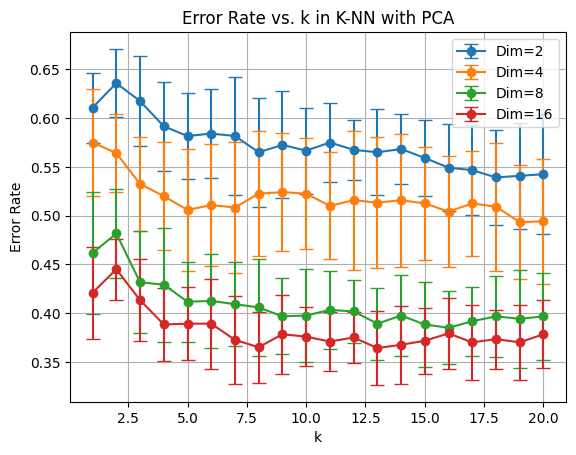

In [14]:
## TODO

# Perform cross-validation search
for dim in [2, 4, 8, 16]:
    data_PCA = PCA(dim=dim)
    data_PCA.train(X_train)
    X_train_Pca = data_PCA.transform(X_train)
    X_val_Pca = data_PCA.transform(X_val)

    # Initialize arrays to store results

    ls = []
    # Perform 10-fold cross-validation for each value of k
    for k in range(1, 21):
        lk = tenfold(KNearestNeighbor, X_train_Pca, y_train, k)
        ls.append(lk)
    ls = jnp.asarray(ls)

    # Plot the mean and standard deviation of error rates
    plt.errorbar(range(1, 21), ls.mean(axis=1), ls.std(axis=1), fmt='-o', capsize=5, label=f'Dim={dim}')
    print("best classifier for the dimension ",dim," in terms of avg is ", range(1, 21)[jnp.argmin(l.mean(axis=1))])

# Customize the plot
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k in K-NN with PCA')
plt.grid(True)
plt.legend()
plt.show()

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>
Higher dimensions seem to provide more information and potentially lower errors, that's what we observe above .
The observation that k=1 often results in lower errors aligns with the nature of the k-nearest neighbors algorithm, where considering only the nearest neighbor can lead to more tailored decision boundaries, especially if the data has clear class separations.
However, it's essential to note that the relationship between the choice of k and the dimensionality of the latent space isn't straightforward. While k=1 may frequently produce optimal results, the behavior of the second-best k value can vary based on factors such as dataset complexity and structure.
</div>

## Weighted $k$-NN

In the classical $k$-NN, all neighbors vote with the same weight towards the predicted class. However, one could argue that this doe not take into account how far these neighbors are. For example, if the example $x$ we want to classify is in a low density region, the value of $k$ may be to high, and the vote is cast by training samples that are very far away from $x$.

To aleviate this problem, we propose to weight the vote cast by the neighbor by the inverse proportion of their distance. Let us denote $x_1, \dots, x_k$ the $k$ nearest neighbors of $x$ in increasing distance order, and let us denote by $d_i = \|x_i - x\|^2$ the squared distance between $x$ and $x_i$. Then, the weight is simply
$$ w_i = \frac{\sum_m d_m}{d_i} $$

<div class="alert alert-warning"> <b>Q6 [Optional].</b>
Implement the weighted $k$-NN class.
</div>

In [15]:
class KNearestNeighbor_weighted():
    def __init__(self, X, y, k=1):
        self.X = X
        self.y =  jnn.one_hot(y, 12) #y  # it was my idea!!
        self.k = k

    '''
    x is a matrix nxd of n samples of dimension d
    returns a vector of size n containing the prediction of the class
    '''
    def __call__(self, x):
        norms1 = jnp.sum(jnp.square(self.X), axis=1)
        norms2 = jnp.sum(jnp.square(x), axis=1)
        D =  np.dot(x, self.X.T)
        dist = (norms1[None,:] + norms2[:,None] - 2*D)
        indices = jnp.argsort(dist, axis=1) #the indices of the k nearest neighbours of x
        dist_to_neighbour = dist[jnp.arange(x.shape[0])[:, None], indices[:, :self.k]]
        # dist_to_neighbour =jnp.take_along_axis(dist, indices[:, 0:self.k], axis=1)
        weights =( dist_to_neighbour.sum(axis = 1)[:,None]  / dist_to_neighbour)
        most_frequent_value = jnp.argmax((self.y[indices[:,0:self.k]]*weights[:,:,None]).sum(axis=1), axis=-1)
        return most_frequent_value

<div class="alert alert-warning"> <b>Q7 [Optional].</b>
Perform the same 10-Fold cross-validation search over $k$ and the PCA dimension for the weighted $k$-NN classifier and analyze your results.
</div>

In [16]:
data_PCA = PCA(dim = 64)
data_PCA.train(X_train)
X_train_Pca= data_PCA.transform(X_train)
X_val_Pca= data_PCA.transform(X_val)

In [17]:
## TODO
#KNN
nn = KNearestNeighbor_weighted(X_train_Pca, y_train, k=1)
y_hat = nn(X_val_Pca)
err = error_rate(y_hat, y_val)
print(err)

0.4166667


In weighted KNN, when k=1, it's evident that we obtain identical results, as there is only one neighbor being considered in the classification. Weighted KNN assigns more importance to closer neighbors, and with k=1, the nearest neighbor has the maximum influence on the classification decision

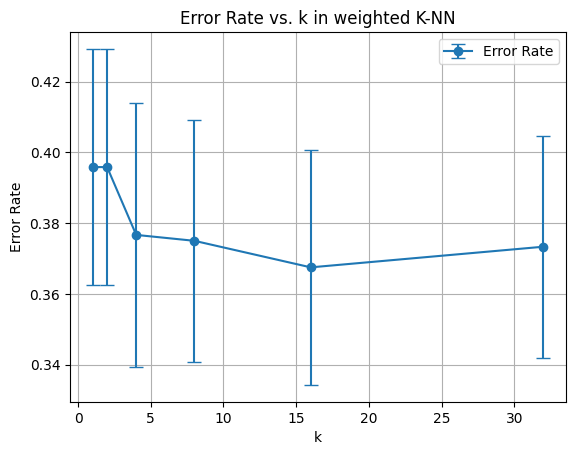

In [18]:
l = []
for k in [1, 2 , 4, 8 , 16 , 32]:
    lk = tenfold(KNearestNeighbor_weighted, X_train_Pca, y_train, k)
    l.append(lk)

l = jnp.asarray(l)

# Plot the mean and standard deviation
plt.errorbar([1, 2 , 4, 8 , 16 , 32], l.mean(axis=1), l.std(axis=1), fmt='-o', capsize=5, label='Error Rate')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k in weighted K-NN')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
print("best classifier in terms of avg is ", [1, 2 , 4, 8 , 16 , 32][jnp.argmin(l.mean(axis=1))])

best classifier in terms of avg is  16


For the first time, we observe that k=1 is not the optimal choice. This outcome was predictable because with k>1, we have more information from multiple neighbors. Additionally, the weights in the weighted KNN algorithm help regularize the influence of neighbors. This regularization is particularly beneficial in scenarios where the nearest neighbor might belong to the opposite class due to noise or overlap near class boundaries. By considering multiple neighbors and adjusting their weights, we can mitigate the impact of such outliers and make more robust classification decisions.

Let's compare K_NN with the weighted one.

In [20]:
lw= []
for k in [1, 2 , 4, 8 , 16 , 32]:
    lk = tenfold(KNearestNeighbor, X_train_Pca, y_train, k)
    lw.append(lk)

lw = jnp.asarray(lw)


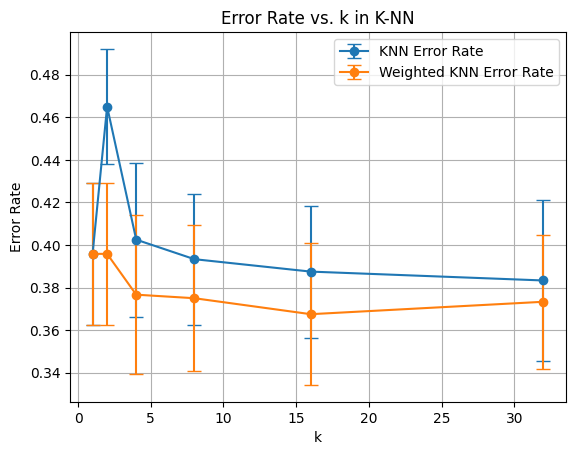

In [21]:
# Plot the mean and standard deviation for KNN
plt.errorbar([1, 2, 4, 8, 16, 32], lw.mean(axis=1), lw.std(axis=1), fmt='-o', capsize=5, label='KNN Error Rate')

# Plot the mean and standard deviation for weighted KNN
plt.errorbar([1, 2, 4, 8, 16, 32], l.mean(axis=1), l.std(axis=1), fmt='-o', capsize=5, label='Weighted KNN Error Rate')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k in K-NN')
plt.grid(True)
plt.legend()
plt.show()

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>
Weighted KNN is better, less error for all the values of k
</div>